# Semantic Image Segmentation

Oxford-IIIT Pet dataset

M. Hawryluk, AGH 2023


## Import modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.utils as utils
import cv2
from random import shuffle, seed

## Data preprocessing

In [2]:
oxford_ds, oxford_info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZJZ4NS/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZJZ4NS/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
next(iter(oxford_ds["train"]))['image'].shape

TensorShape([500, 500, 3])

In [4]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

def resize(image):
   return tf.image.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), method="nearest")

In [5]:
def preprocess_data(data):
   image = data["image"]
   mask = data["segmentation_mask"]

   image = resize(image)
   mask = resize(mask)

   image = tf.cast(image, tf.float32) / 255.0
   mask -= 1

   return image, mask

In [6]:
ds_train = oxford_ds["train"].map(preprocess_data)
ds_test = oxford_ds["test"].map(preprocess_data)

In [7]:
next(iter(ds_train))[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01960784, 0.01176471, 0.01568628],
        [0.02352941, 0.01568628, 0.01960784],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.01176471, 0.00392157, 0.00784314],
        [0.00392157, 0.00392157, 0.        ],
        [0.02745098, 0.01176471, 0.01568628]],

       [[0.01176471, 0.01176471, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.01960784, 0.01176471, 0.01568628],
        ...,
        [0.00392157, 0.        , 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.01568628, 0.01568628, 0.01568628]],

       [[0.01176471, 0.01960784, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.02352941, 0.01960784],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.01960784, 0.01176471, 0.01568628],
        [0.01960784, 0.01176471, 0.02352941]],

       ...,

       [[0.02745098, 0.02745098, 0.03529412],
        [0.01

In [8]:
example_mask = next(iter(ds_train))[1].numpy()
np.unique(example_mask)

array([0, 1, 2], dtype=uint8)

In [9]:
batch_size = 64

ds_train_batched = ds_train.cache().batch(batch_size).repeat()
ds_val_batched = ds_test.take(3000).batch(batch_size)
ds_test_batched = ds_test.skip(3000).batch(batch_size)

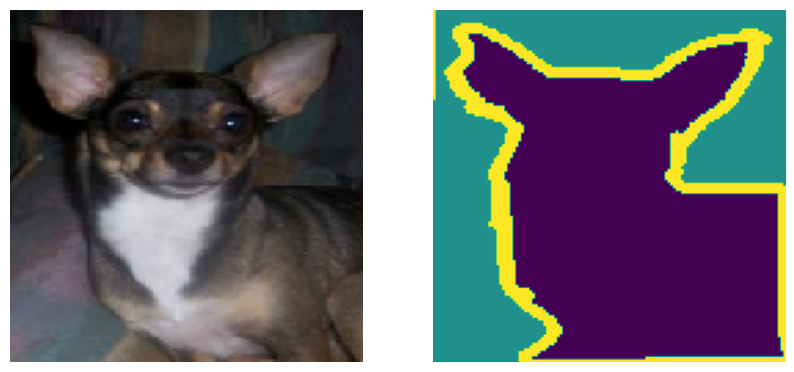

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

x, y = next(iter(ds_train.skip(13)))

ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(x)
ax[1].imshow(y)

plt.show()

## Neural segmentation model
### Unet

In [11]:
def encoding_block(x, num_filters):
  a = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
  b = layers.MaxPool2D(2)(a)
  b = layers.Dropout(0.2)(b)
  return a, b

def decoding_block(x, s, num_filters):
  x = layers.Conv2DTranspose(num_filters, 3, 2, padding="same")(x)
  x = layers.concatenate([x, s])
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
  return x

def unet(num_classes=3):
  inputs = layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

  # encoder
  s1, e1 = encoding_block(inputs, 64)
  s2, e2 = encoding_block(e1, 128)
  s3, e3 = encoding_block(e2, 256)
  s4, e4 = encoding_block(e3, 512)
  b = layers.Conv2D(1024, 3, padding="same", activation="relu")(e4)

  # decoder
  d1 = decoding_block(b, s4, 512)
  d2 = decoding_block(d1, s3, 256)
  d3 = decoding_block(d2, s2, 128)
  d4 = decoding_block(d3, s1, 64)
  outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

  return keras.Model(inputs, outputs)

In [12]:
def get_mask(prediction):
 mask = tf.argmax(prediction, axis=-1)
 mask = mask[..., tf.newaxis]
 return mask[0]

In [13]:
model = unet()
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics="accuracy"
)

In [14]:
# !unzip model.zip
# model = keras.models.load_model('pets-1')

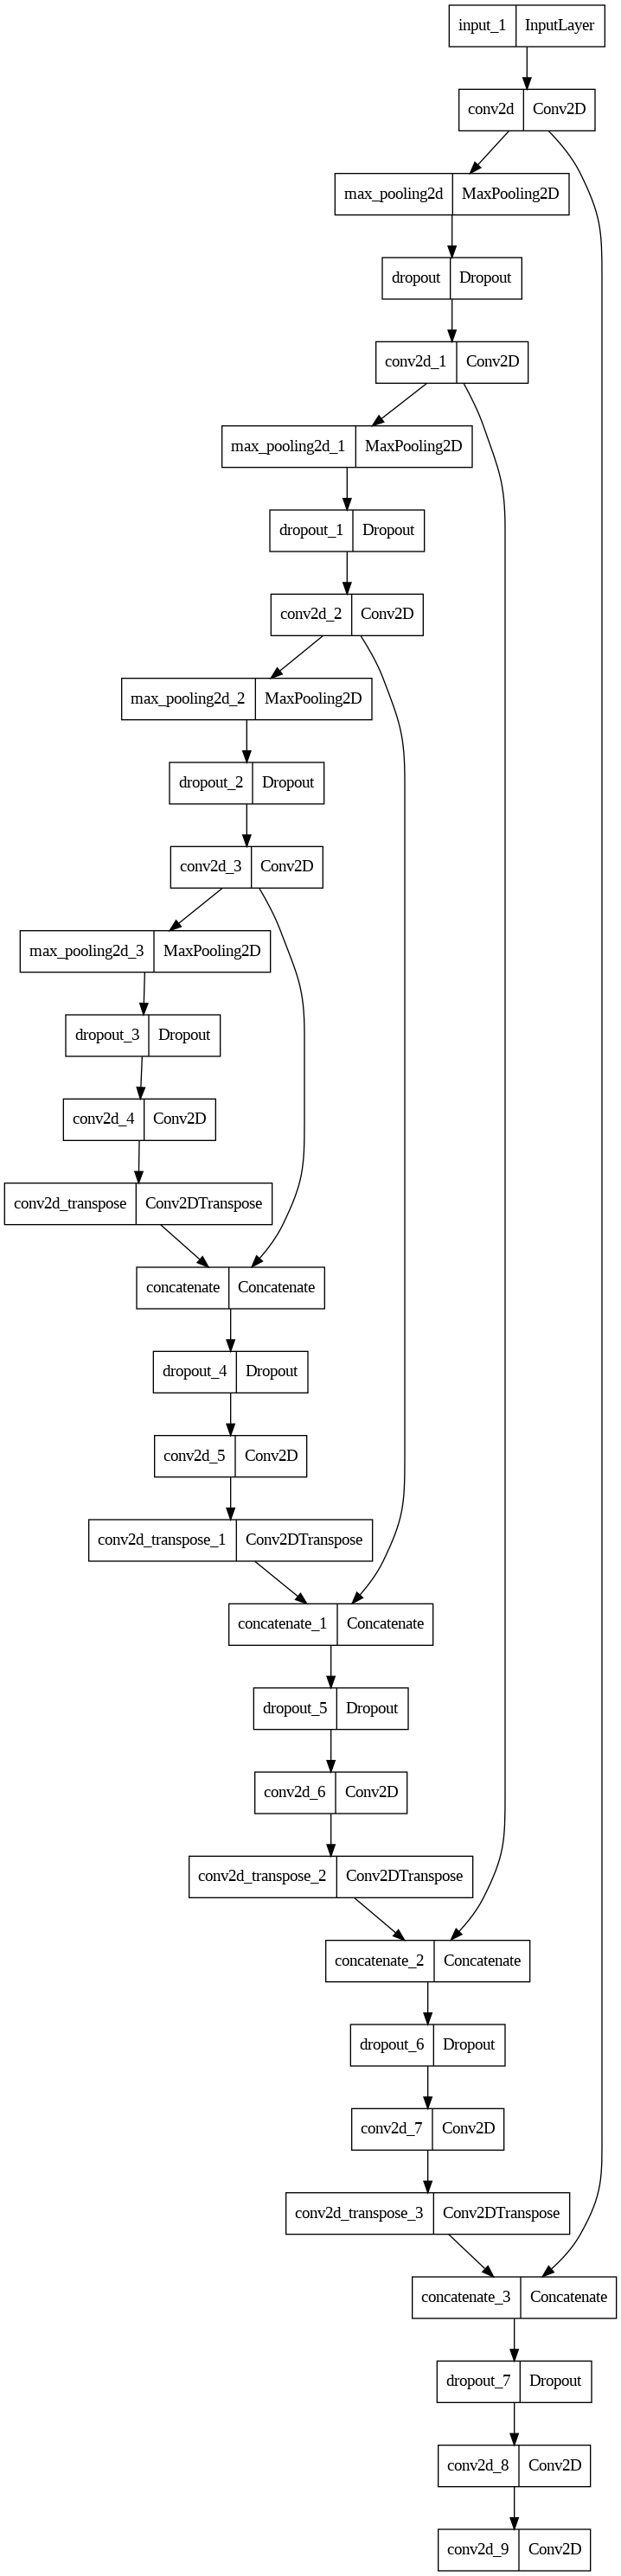

In [14]:
utils.plot_model(model)

In [15]:
epochs = 20

model_history = model.fit(
    ds_train_batched,
    epochs=epochs,
    steps_per_epoch=oxford_info.splits["train"].num_examples // batch_size,
    validation_steps=oxford_info.splits["test"].num_examples // batch_size // 5,
    validation_data=ds_val_batched
)

Epoch 1/20
57/57 [==============================] - 74s 693ms/step - loss: 0.9493 - accuracy: 0.5802 - val_loss: 0.9258 - val_accuracy: 0.5733
Epoch 2/20
57/57 [==============================] - 63s 828ms/step - loss: 0.8775 - accuracy: 0.5850 - val_loss: 0.8502 - val_accuracy: 0.5814
Epoch 3/20
57/57 [==============================] - 39s 686ms/step - loss: 0.8110 - accuracy: 0.6173 - val_loss: 0.7526 - val_accuracy: 0.6921
Epoch 4/20
57/57 [==============================] - 39s 691ms/step - loss: 0.6677 - accuracy: 0.7297 - val_loss: 0.6357 - val_accuracy: 0.7440
Epoch 5/20
57/57 [==============================] - 39s 693ms/step - loss: 0.6172 - accuracy: 0.7523 - val_loss: 0.5935 - val_accuracy: 0.7632
Epoch 6/20
57/57 [==============================] - 39s 687ms/step - loss: 0.5620 - accuracy: 0.7771 - val_loss: 0.5625 - val_accuracy: 0.7787
Epoch 7/20
57/57 [==============================] - 39s 694ms/step - loss: 0.5238 - accuracy: 0.7941 - val_loss: 0.5101 - val_accuracy: 0.7973

In [16]:
model.save('pets-1')
!zip model.zip pets-1/*

  adding: pets-1/assets/ (stored 0%)
  adding: pets-1/fingerprint.pb (stored 0%)
  adding: pets-1/keras_metadata.pb (deflated 94%)
  adding: pets-1/saved_model.pb (deflated 90%)
  adding: pets-1/variables/ (stored 0%)


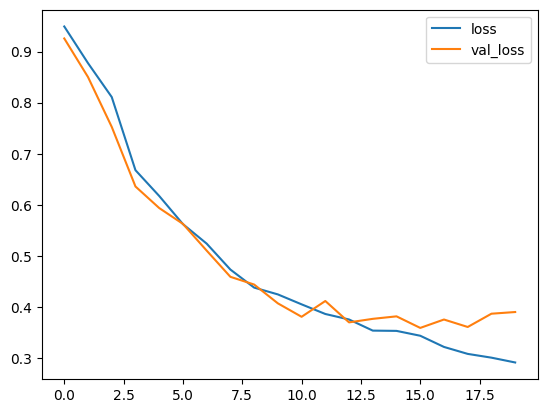

In [17]:
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [18]:
predicted = model.predict(ds_test_batched)

11/11 [==============================] - 16s 828ms/step


1/1 [==============================] - 0s 18ms/step


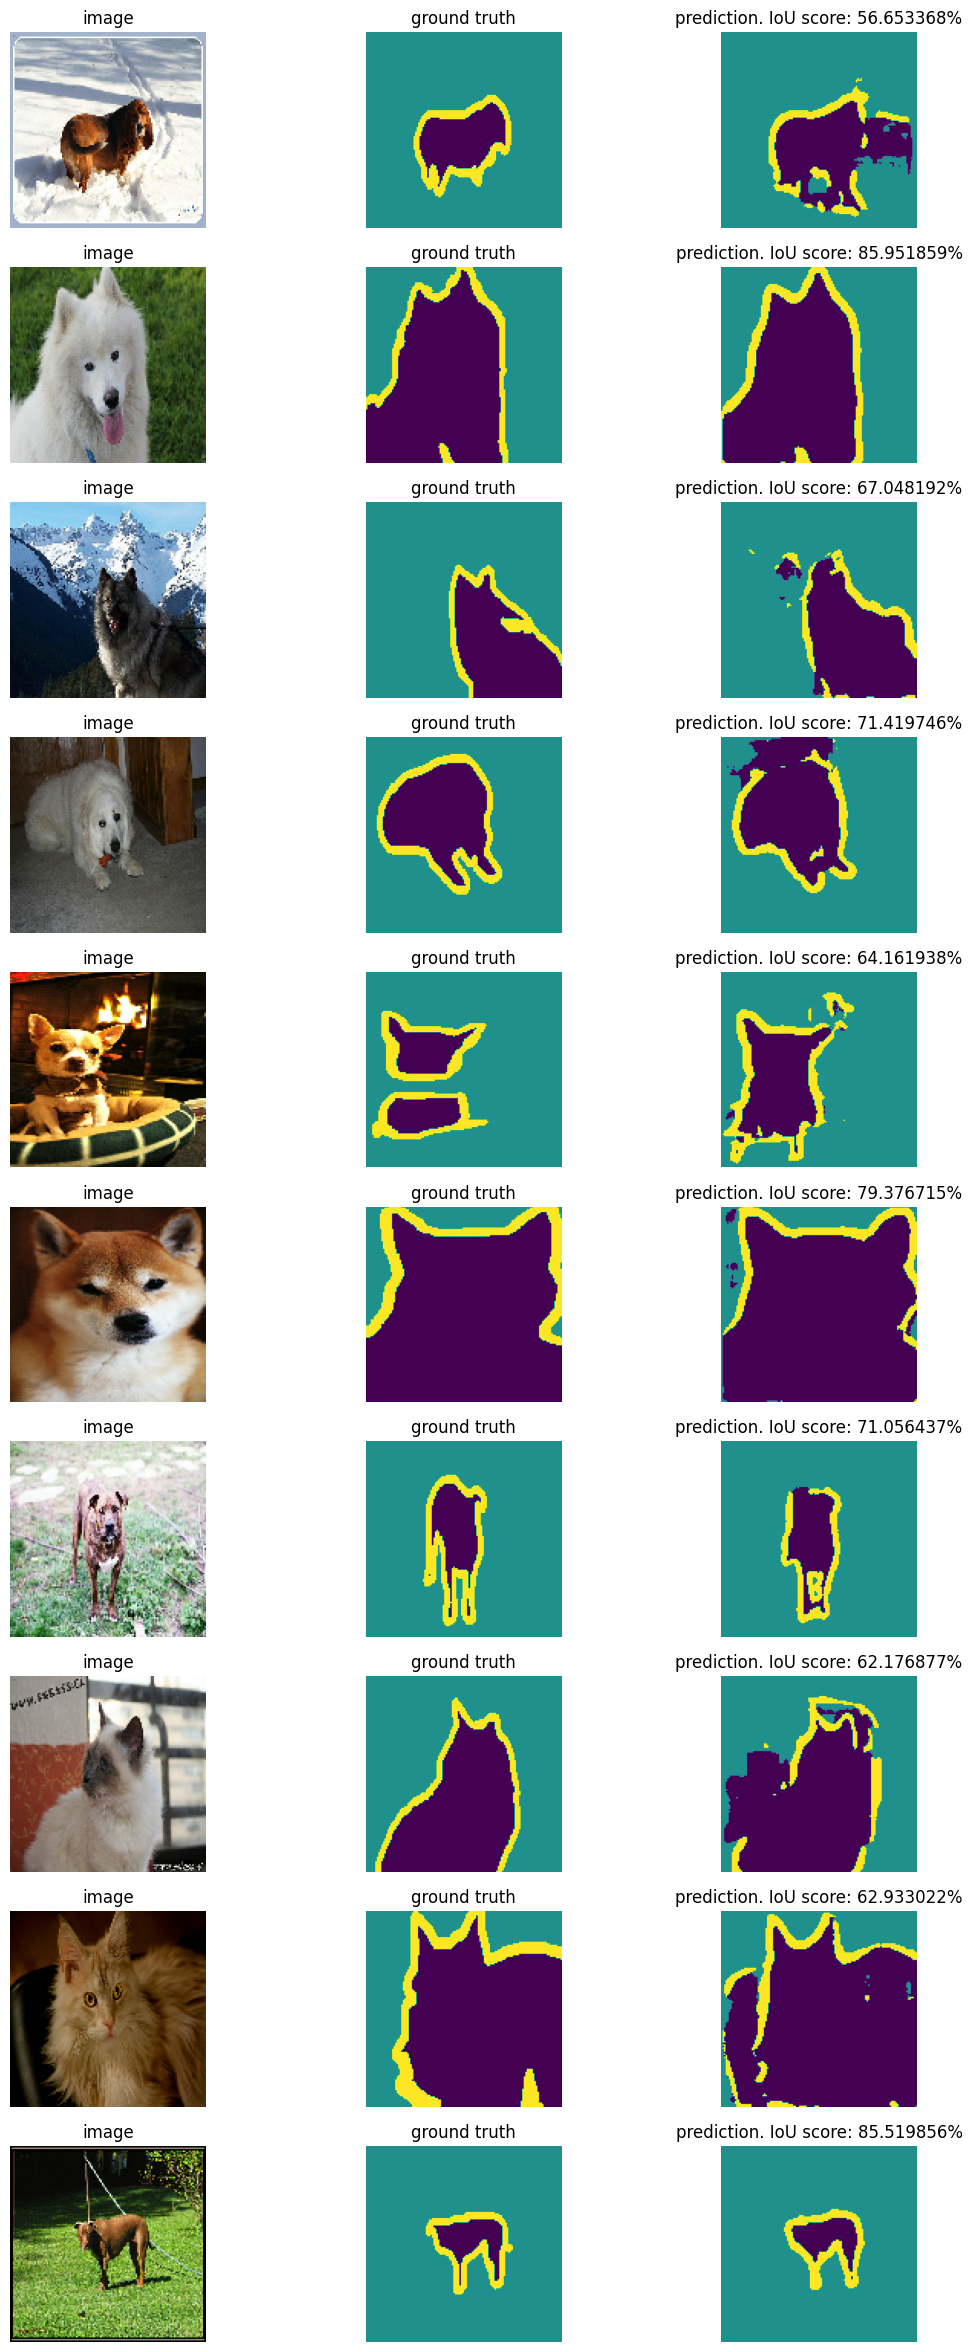

In [19]:
fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i, (x, y) in enumerate(ds_test.skip(10).take(10)):
  y_pred = get_mask(model.predict(tf.expand_dims(x, axis=0)))
  score = keras.metrics.IoU(3, target_class_ids=list(range(3)))(y_pred, y)

  ax[i][0].axis('off')
  ax[i][1].axis('off')
  ax[i][2].axis('off')

  ax[i][0].set_title('image')
  ax[i][1].set_title('ground truth')
  ax[i][2].set_title(f'prediction. IoU score: {score:%}')

  ax[i][0].imshow(x)
  ax[i][1].imshow(y)
  ax[i][2].imshow(y_pred)

plt.show()

## Transfer learning

## Hyperparameter space search

## Classic approach

In [20]:
(image, result) = next(iter(ds_test.skip(11).take(1)))

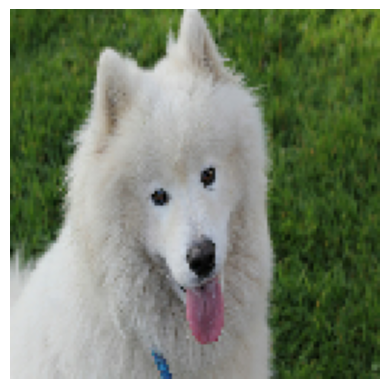

In [23]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [24]:
image_gray = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2GRAY)*255

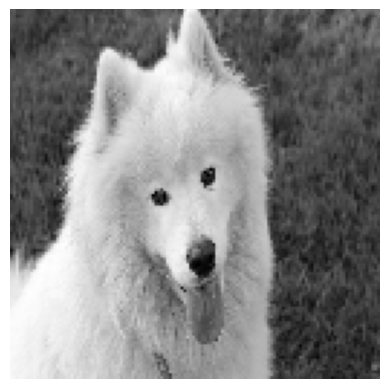

In [29]:
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

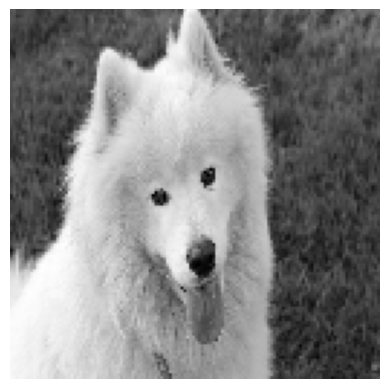

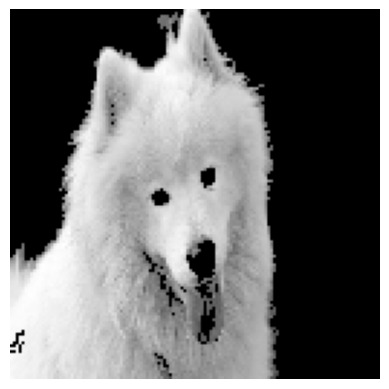

In [30]:
def segmentation_classic(img, predicate, start_x, start_y):
    visited = np.zeros(img.shape, dtype=bool)
    segmented = np.zeros(img.shape)

    stack = [(start_x, start_y)]
    visited[start_x, start_y] = True
    segmented[start_x, start_y] = img[start_y, start_y]

    mv = 0
    ns = 0

    while stack:
        x, y = stack.pop()
        ns += 1
        mv = (mv*(ns-1)+img[x, y])/ns

        if 0 < x < img.shape[0] - 1 and 0 < y < img.shape[1] - 1:
            for neigh_x in range(x-1, x+2):
                for neigh_y in range(y-1, y+2):
                    if not visited[neigh_x, neigh_y] and predicate(img[neigh_x, neigh_y], mv):
                        segmented[neigh_x, neigh_y] = img[neigh_x, neigh_y]
                        stack.append((neigh_x, neigh_y))
                    visited[neigh_x, neigh_y] = True

    return segmented

segmented = segmentation_classic(img=image_gray, predicate=lambda x, y: abs(x-y) < 70, start_x=50, start_y=50)

plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

In [27]:
canny_lib_result = cv2.Canny(np.uint8(segmented), 120, 240, None, 3, 1)

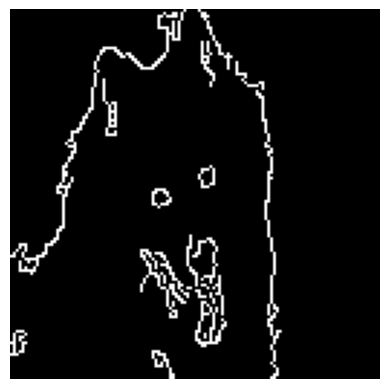

In [31]:
plt.imshow(canny_lib_result, cmap='gray')
plt.axis('off')
plt.show()